In [2]:
import jax
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from typing import Sequence, Union
import lib
from sklearn.cluster import KMeans
import sklearn
import optax
from tqdm import tqdm

In [3]:
time_delay_dim = 10
time_delay = 10
time_range = (0, 600, 0.02)
n_centers = 500

In [6]:
class sinusodials(lib.stimulus_base_class):
    def __init__(self, time_range, amplitude, periods, coeffs, phases, dc_stimulus=0) -> None:
        """amplitude: the overall amplitude of the stimulus
        periods: a list of periods for sinusodial waves, the unit is ms"""
        super().__init__(time_range, initial_state=None, time_constant=1, rescale_factor=1, dc_stimulus=dc_stimulus)
        self.amplitude = amplitude
        self.periods = periods
        self.coeffs = coeffs
        self.phases = phases
        self.get_stimulus_list()

    def get_stimulus_list(self):
        times = np.arange(*self.time_range)
        sums = np.zeros(times.shape)
        for i in range(len(self.periods)):
            sums += self.coeffs[i]*np.sin(2*np.pi/self.periods[i]*times + self.phases[i])
        max_amp = np.max(np.abs(sums))
        sums = self.amplitude/max_amp*sums
        self.stimulus_list = sums + self.dc_stimulus
        

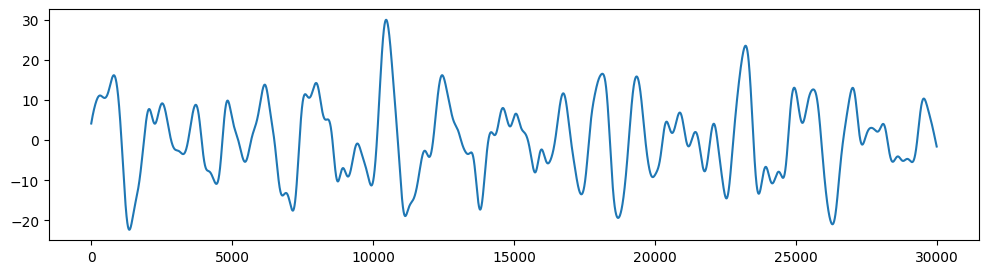

In [114]:
rescale_factor = 1
n_sins = 100
np.random.seed(0)
periods = np.random.uniform(5, 50, n_sins)
periods = periods[np.argsort(np.abs(periods))]
# coeffs = np.random.normal(loc=0, scale=0.25, size=n_sins)
coeffs = np.random.uniform(0, 1, n_sins)
coeffs = coeffs[np.argsort(np.abs(coeffs))]
phases = np.random.uniform(0, 1, n_sins)*2*np.pi
sin_stimulus = sinusodials(time_range, amplitude=30, periods=periods, coeffs=coeffs, phases=phases)

lorenz63_stimulus = lib.lorenz1963_stimulus(time_range=time_range, rescale_factor=1.5, initial_state=[-3.5, -3.0, 21.], time_constant=10,rho=28, sigma=10, beta=8/3)
lorenz63_stimulus.get_stimulus_list()

plt.figure(figsize=(12, 3))
plt.plot(sin_stimulus.stimulus_list)

In [115]:
training_neuron = lib.single_neuron_odeint(sin_stimulus, [0, 0, 0, 0])
training_neuron.generate_sol()

training_neuron2 = lib.single_neuron_odeint(lorenz63_stimulus, [0, 0, 0, 0])
training_neuron2.generate_sol()

In [116]:
drop_first_n_points = 5000
training_neuron.sol = training_neuron.sol[drop_first_n_points:]
sin_stimulus.stimulus_list = sin_stimulus.stimulus_list[drop_first_n_points:]

training_neuron2.sol = training_neuron2.sol[drop_first_n_points:]
lorenz63_stimulus.stimulus_list = lorenz63_stimulus.stimulus_list[drop_first_n_points:]

Text(0.5, 0, 'time (ms)')

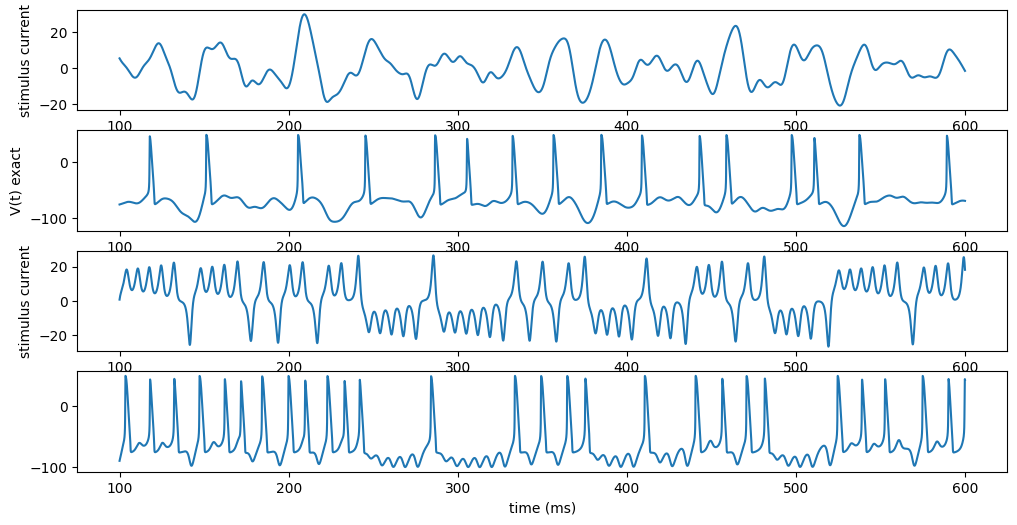

In [117]:
fig, axes = plt.subplots(4, 1,  figsize=(12, 6))

axes[0].plot(np.arange(*time_range)[drop_first_n_points:], sin_stimulus.stimulus_list)
axes[0].set_ylabel("stimulus current")
axes[1].plot(np.arange(*time_range)[drop_first_n_points:], training_neuron.sol[:, 0])
axes[1].set_ylabel("V(t) exact")
axes[2].plot(np.arange(*time_range)[drop_first_n_points:], lorenz63_stimulus.stimulus_list)
axes[2].set_ylabel("stimulus current")
axes[3].plot(np.arange(*time_range)[drop_first_n_points:], training_neuron2.sol[:, 0])
axes[3].set_xlabel("time (ms)")

(-80.0, -60.0)

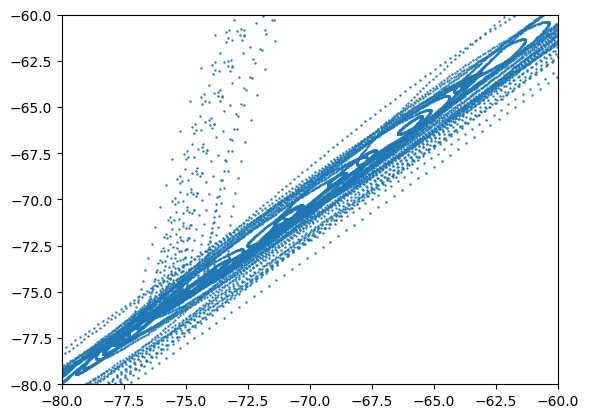

In [73]:
plt.scatter(training_neuron.sol[10:, 0], training_neuron.sol[:-10, 0], s=0.5)
plt.xlim(-80, -60)
plt.ylim(-80, -60)